In [1]:
import scvelo as scv
import numpy as np
import pandas as pd

import scanpy as sc

In [2]:
adata = scv.datasets.pancreas()


In [3]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [4]:
hvg = np.loadtxt("./ZPSGenes.tsv",dtype=str)
hvg.shape

(1352,)

In [5]:
filtered = adata[:,hvg]

# Generating an Embedding

In [ ]:
# We will need two embeddings, one small (10ish?) and linear and one even smaller, on the small linear, in 2d. 

In [ ]:
# We will also need velocities in the embedding space. The two possible approaches are velocity-graph based or possibly KNN smoothed? 

In [ ]:
# Garden of branching paths: 
# Generate knn graph in NMF space or gene space?

# Generating velocity
# Spliced, unspliced into ESpliced EUnspliced, model on ES + EU

# Generate T0 and Velocity in gene space then embed to get TE0 and VE

# Generate T0 and Velocity, then generate T1 in gene space, embed to get TE0, TE1

# Smoothing + plausible velocities
# You can just smooth plain velocities by KNN (either in gene space or in embedding space) 
# You can get most plausibly pointed to cells in the KNN and generate the transition probabilities



# Generate velocity by transforming 

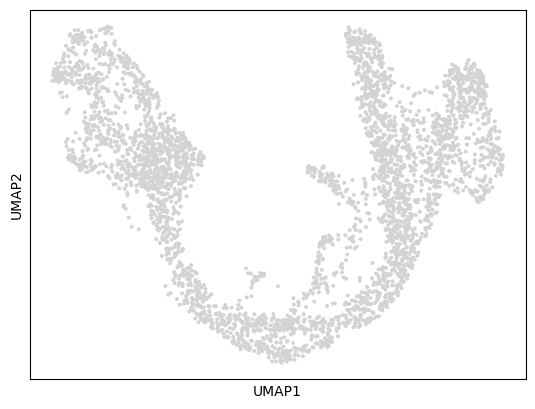

In [6]:
# Preliminarily, order of operations is: PCA (ICA? NMF? PCA for now) , KNN smooth, velocity in gene space (so just get the raw velocity)

# Embed into a low NMF, raw velocity in low NMF

sc.pp.neighbors(filtered)
sc.tl.umap(filtered)
sc.pl.umap(filtered)

In [7]:
scv.pp.moments(filtered,n_neighbors=None,n_pcs=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
scv.tl.velocity(filtered)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/bbrener1/miniconda3/envs/forecaster/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [9]:
filtered.layers['velocity']

array([[-0.15834415,  0.        ,  0.09516238, ...,  0.04701879,
         0.028987  , -0.28086394],
       [ 0.01048369, -0.03122842,  2.0656872 , ..., -0.08585416,
        -0.03060386,  0.02902997],
       [-0.06699599,  0.        ,  0.10111722, ...,  0.11774952,
         0.05883906, -0.05176263],
       ...,
       [-0.05809785,  0.06336732,  3.6470673 , ...,  0.        ,
         0.17588457, -0.13478523],
       [ 0.03611044,  0.        , -0.32636806, ..., -0.01479846,
         0.18808877,  0.01429427],
       [ 0.0233413 ,  0.04404343,  0.0609413 , ...,  0.08628574,
         0.03104521,  0.06689584]], dtype=float32)

### Medium NMF Embedding 

In [10]:
from sklearn.decomposition import NMF,PCA
import matplotlib.pyplot as plt

In [11]:
# The NMF is skittish about operating on negative values, but we can ask it to

t0 = np.array(filtered.X.todense())
# t0 = k_smooth(t0,t0,n_neighbors=15)
# t1 = t0 + np.array(filtered.layers['velocity']) # This is about 20% negative

# inverted 


In [16]:
t0 = k_smooth(t0,t0,n_neighbors=15)

In [17]:
nmf_model = NMF(n_components=50)
p_t0 = nmf_model.fit_transform(t0)
a_t0 = nmf_model.components_

# Has the velocity in ['velocity'] been KNNed? I sure hope so

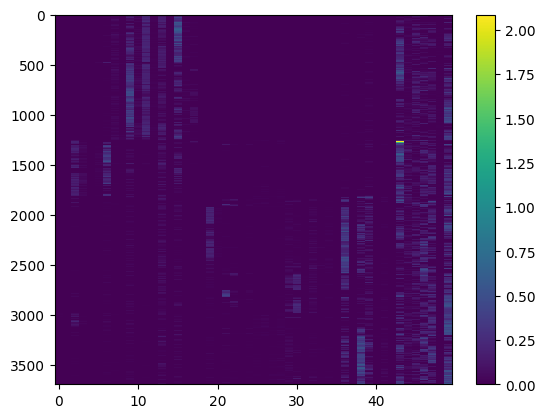

In [18]:
cell_sort = single_agg(p_t0)
feature_sort = single_agg(p_t0.T)

plt.figure()
plt.imshow(p_t0[cell_sort].T[feature_sort].T,aspect='auto',interpolation='none')
plt.colorbar()
plt.show()

In [20]:
smooth_velocity = filtered.layers['velocity']
smooth_velocity = k_smooth(smooth_velocity,p_t0,n_neighbors=15)



In [ ]:
# t1 = t0 + (smooth_velocity / 5) # This is about 20% negative

# (p_t1,_,_,_) = np.linalg.lstsq(a_t0.T,t1.T)
# p_t1 = p_t1.T
# p_t1.shape

In [41]:
embedded_velocity,_,_,_ = np.linalg.lstsq(a_t0.T,smooth_velocity.T)
embedded_velocity = embedded_velocity.T

p_t1 = p_t0 + (embedded_velocity/1000)
p_t1[p_t1 < 0] = 0

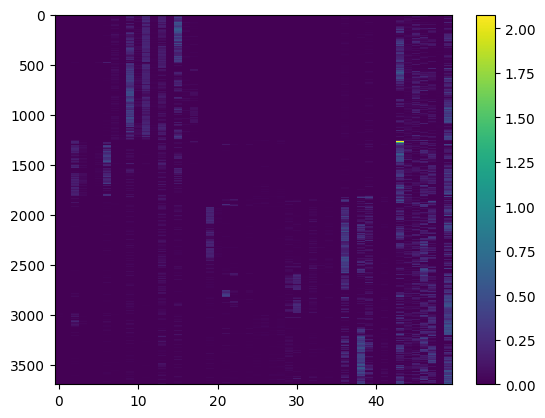

In [27]:
plt.figure()
plt.imshow(p_t1[cell_sort].T[feature_sort].T,aspect='auto',interpolation='none')
plt.colorbar()
plt.show()

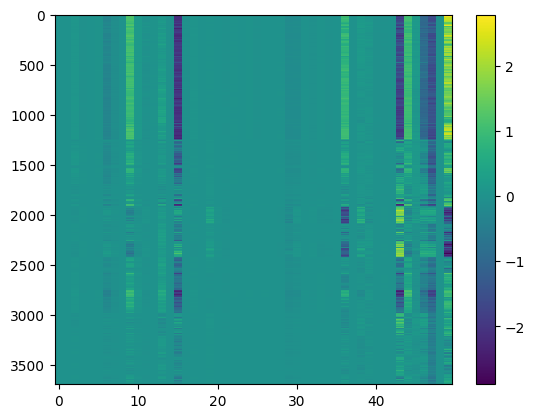

In [26]:
plt.figure()
# plt.imshow(embedded_velocity[cell_sort].T[feature_sort].T,aspect='auto',interpolation='none',cmap='bwr',vmin=-2,vmax=2)
plt.imshow(embedded_velocity[cell_sort].T[feature_sort].T,aspect='auto',interpolation='none')
plt.colorbar()
plt.show()

In [42]:
# Exfil
np.savetxt("sc_velo_t0_emb.tsv",p_t0)
np.savetxt("sc_velo_t1_pred_emb.tsv",p_t1)

In [28]:
# stacked P in case we want to do a joint embedding 
stacked_p = np.vstack([p_t0,p_t1])

### Medium PCA Embedding

In [ ]:
pca_model = PCA(n_components=50)
pca_t0 = pca_model.fit_transform(t0)

In [ ]:
smooth_velocity = filtered.layers['velocity']
smooth_velocity = k_smooth(smooth_velocity,t0,n_neighbors=5)


### Manual UMAP

In [29]:
from umap import UMAP
from umap.umap_ import nearest_neighbors

In [30]:
umap_model = UMAP(n_neighbors=15,min_dist=0.5, spread=1.0, n_components=2, negative_sample_rate=5, random_state=0,metric='cosine')
umap_model.fit(stacked_p)
u_t = umap_model.transform(stacked_p)


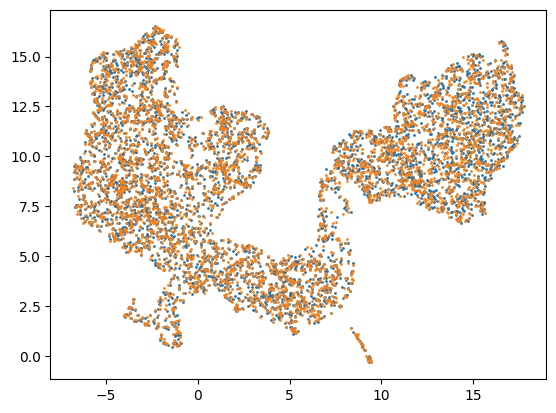

In [31]:
plt.figure()
plt.scatter(*u_t[:3696].T,s=1)
plt.scatter(*u_t[3696:,].T,s=1)
# plt.scatter(*k_smooth(u_t[:3696],p_t0,n_neighbors=5,metric='euclidean').T,s=1)
plt.show()

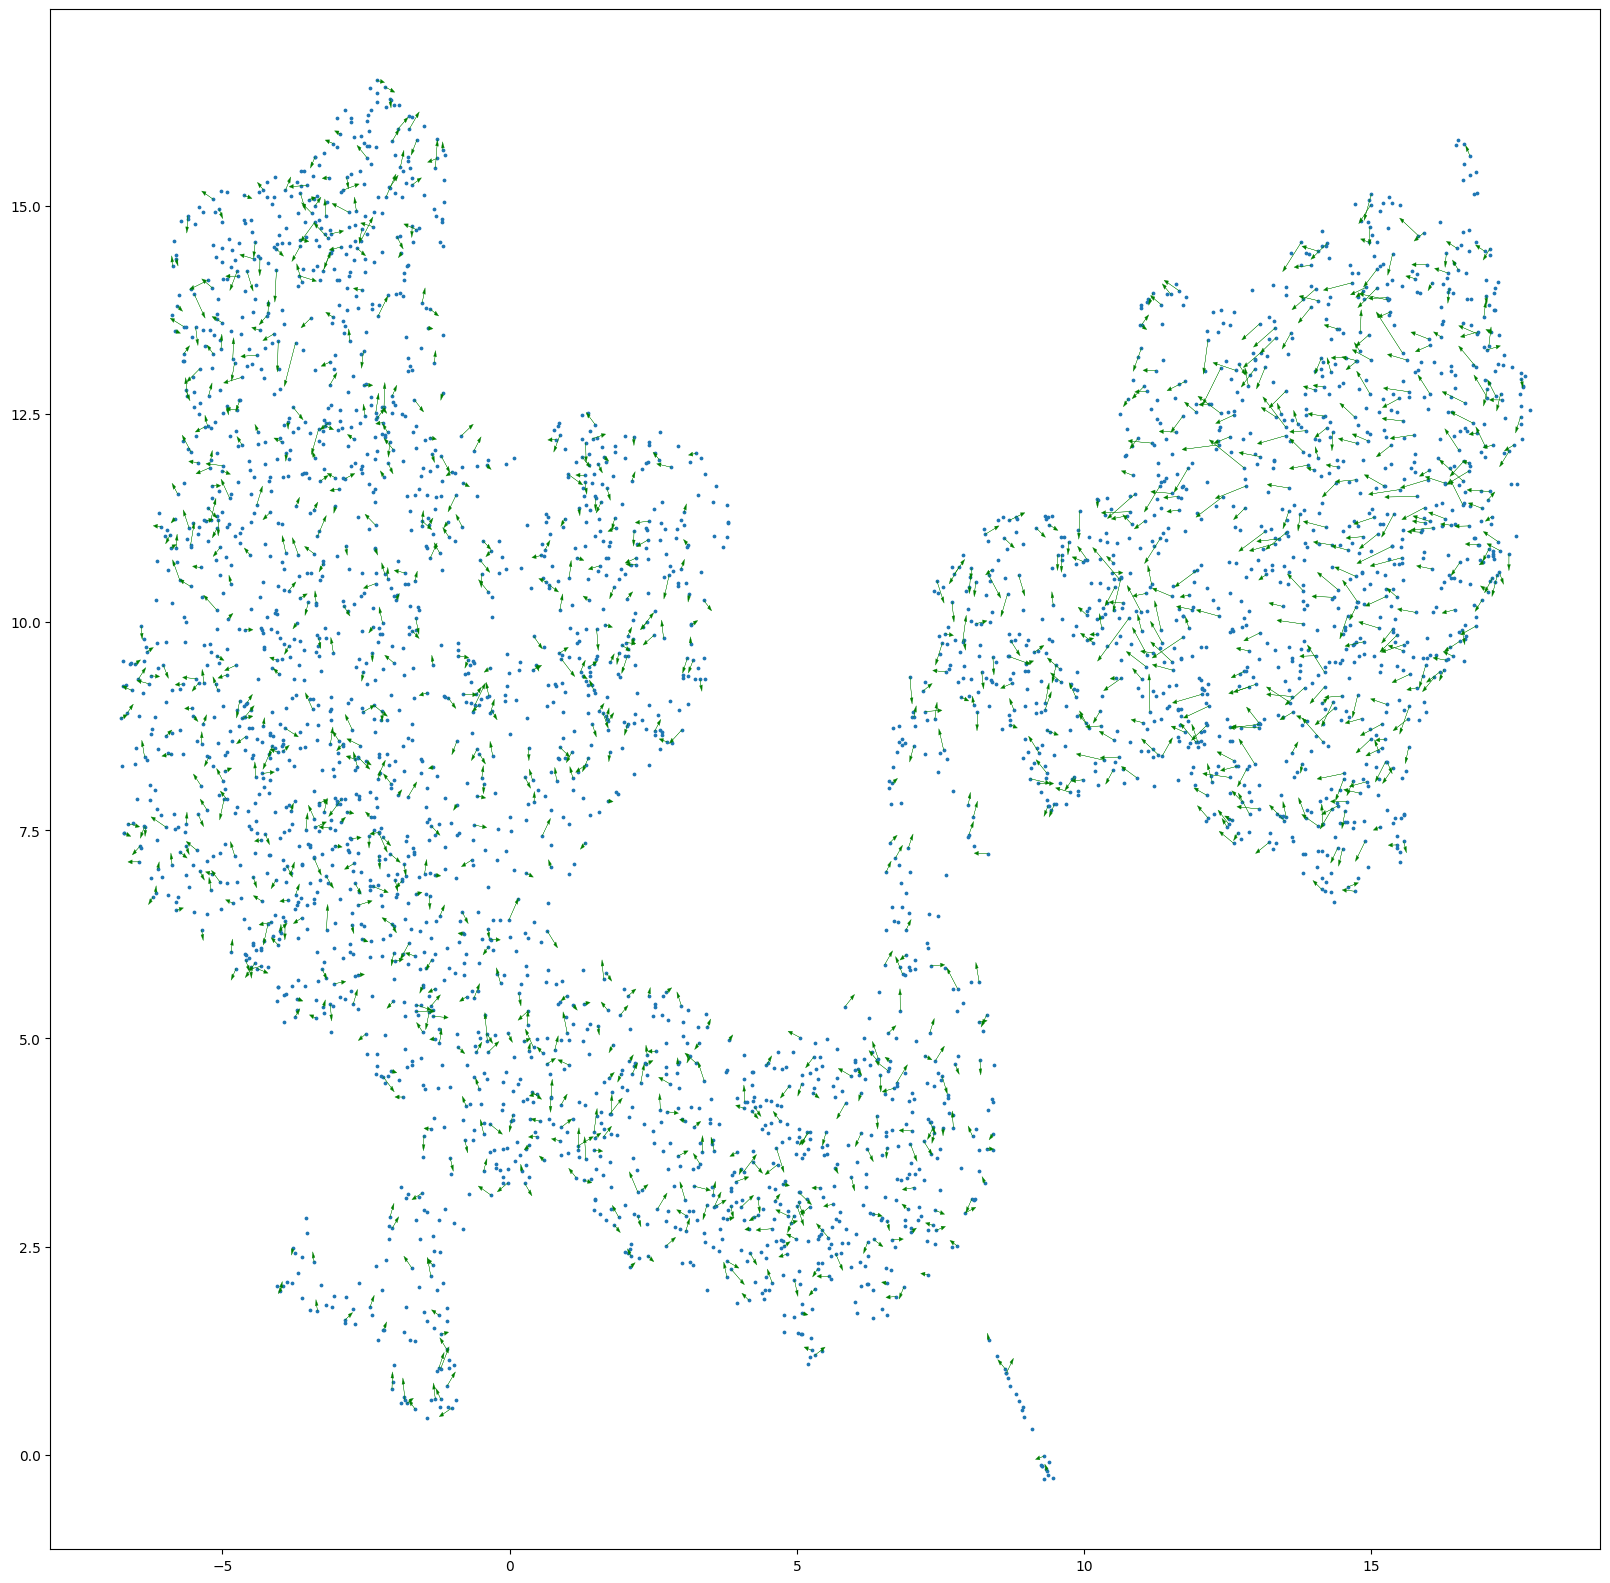

In [32]:
trajectory_series([u_t[:3696],u_t[3696:]],frequency=3,figsize=(20,20))

In [34]:
# Joint UMAP Of Foreign Trajectories

In [139]:
t_1 = np.loadtxt("./trajectories_t1.tsv",dtype=float).T
t_2 = np.loadtxt("./trajectories_t2.tsv",dtype=float).T
t_3 = np.loadtxt("./trajectories_t3.tsv",dtype=float).T
t_4 = np.loadtxt("./trajectories_t4.tsv",dtype=float).T
t_5 = np.loadtxt("./trajectories_t5.tsv",dtype=float).T
t_6 = np.loadtxt("./trajectories_t6.tsv",dtype=float).T

In [140]:
t_1e = umap_model.transform(t_1)
t_2e = umap_model.transform(t_2)
t_3e = umap_model.transform(t_3)
t_4e = umap_model.transform(t_4)
t_5e = umap_model.transform(t_5)

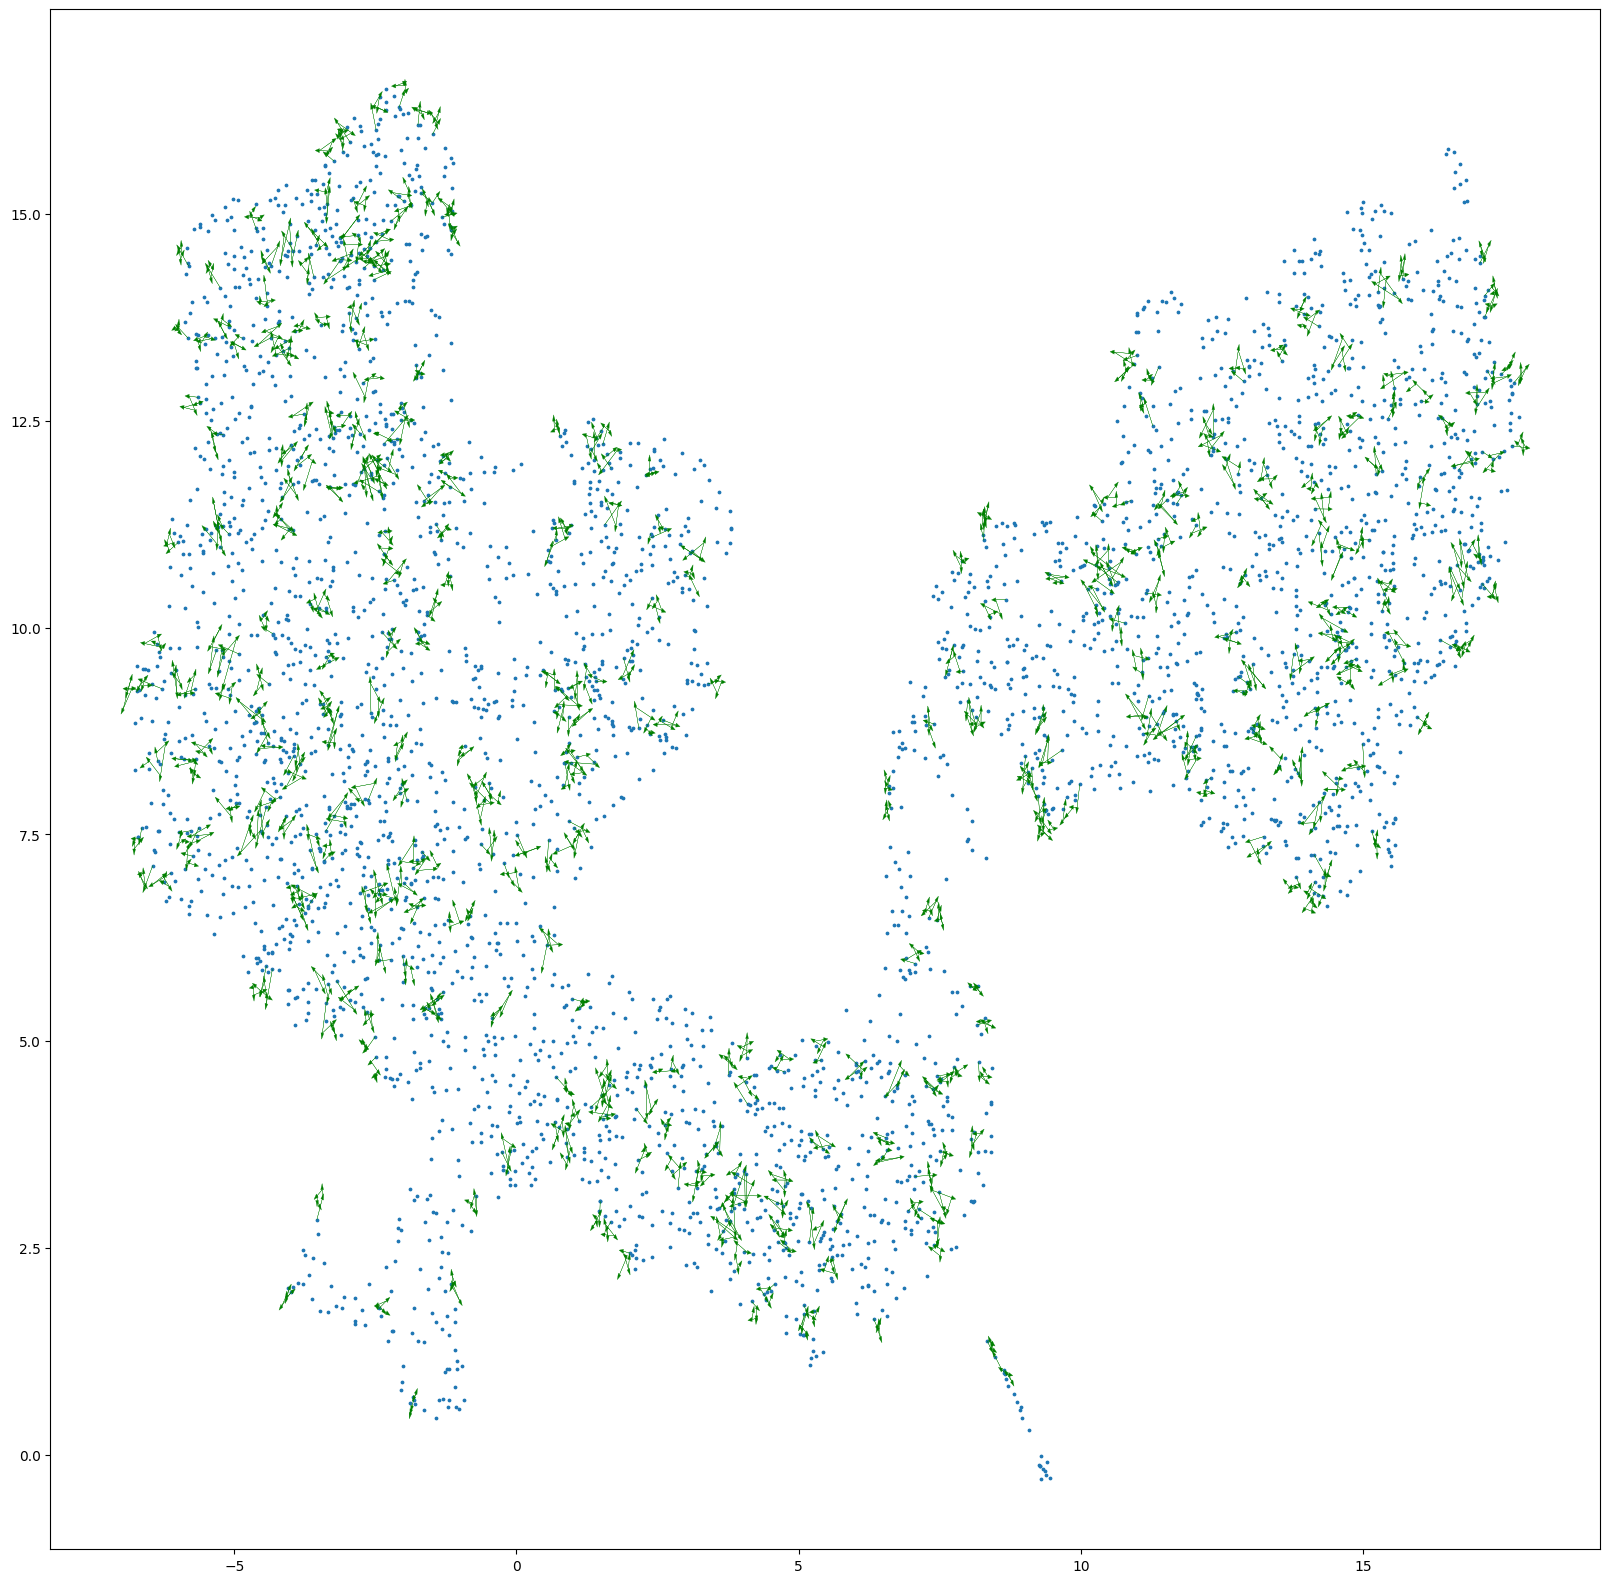

In [142]:
trajectory_series([u_t[:3696],t_1e,t_2e,t_3e,t_4e,t_5e],frequency=10,figsize=(20,20))
# trajectory_series([u_t[:3696],t_1e],frequency=3,figsize=(20,20))

In [ ]:
# Investigate if the curl is legitimate or an artifact of UMAP (plot distance from t0 for all steps?)

In [ ]:
# Investigate strength of smoothing 

In [ ]:
# Investigate embedding after the time step?

In [ ]:
# Investigate consistency of direction before/after smoothing and in general 
# Investigate if truncation helps?

In [ ]:
# Investigate the insensitivity to the necking parameter? k=2? Really? =/

In [13]:
from scipy.cluster.hierarchy import linkage,dendrogram

def single_agg(mtx,metric='cosine',method='average'):
    return dendrogram(linkage(mtx, metric=metric, method=method), no_plot=True)['leaves']

def double_agg(mtx,metric='cosine',method='average'):
    row_agg = dendrogram(linkage(mtx, metric=metric, method=method), no_plot=True)['leaves']
    col_agg = dendrogram(linkage(mtx.T, metric=metric, method=method), no_plot=True)['leaves']
    return mtx[row_agg].T[col_agg].T


In [14]:
def arrow_deltas(t1,t2):
    x,y = t1
    dx,dy = t2 - t1
    return (x,y,dx,dy)

def trajectory_series(trajectories,frequency=5,figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.scatter(*trajectories[0].T,s=3)
    for t1,t2 in zip(trajectories[:-1],trajectories[1:]):
        for i in range(0,t1.shape[0],frequency): 
            plt.arrow(*arrow_deltas(t1[i],t2[i]),color='green',head_width=.05,linewidth=.2)
    plt.show()    


In [112]:
from sklearn.neighbors import NearestNeighbors

def k_smooth(data,basis,n_neighbors=15,metric='cosine'):
    knn_model = NearestNeighbors(n_neighbors=n_neighbors,metric=metric).fit(data)    
    neighbors = knn_model.kneighbors()[1]
    sum_matrix = np.zeros(data.shape)
    for neighbor in neighbors.T:
        sum_matrix += data[neighbor]
    sum_matrix /= neighbors.shape[1]
    # print(data[0])
    # print(sum_matrix[0])
    # print(data[neighbors[0]])
    # print(neighbors[0])
    return sum_matrix

# Is UMAP the problem? 

In [ ]:
# Approaches:
# - Correlation with a neighborhood vs on the umap
# - Distance increase when curling?

In [131]:
from scipy.spatial.distance import cosine,pdist,squareform

# Velocity neighborhood cosine
def neighborhood_smoothness(velocity,basis,n_neighbors=15,metric='cosine'):
    knn_model = NearestNeighbors(n_neighbors=n_neighbors,metric=metric).fit(basis)    
    neighborhoods = knn_model.kneighbors()[1]
    mean_distances = []
    for neighborhood in neighborhoods:
        # print(neighborhood.shape)
        velocities = velocity[neighborhood]
        neighborhood_distance = squareform(pdist(velocities))
        mean_distance = np.mean(neighborhood_distance.flatten())
        mean_distances.append(mean_distance)

    plt.figure()
    plt.hist(mean_distances)
    plt.xlabel("Mean neighborhood distance measure")
    plt.ylabel("Frequency")
    plt.show()
    return np.array(mean_distances)

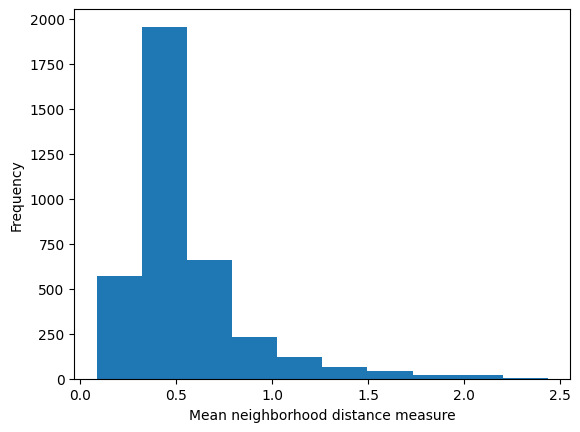

In [132]:
smoothness = neighborhood_smoothness(embedded_velocity,p_t0)

In [75]:
embedded_velocity.shape

(3696, 50)

In [135]:
# Now we need the umap embedding of the velocities 

umap_velocity = u_t[3696:] - u_t[:3696] 

In [136]:
umap_velocity

array([[ 0.1271267 , -0.02506638],
       [-0.03344154, -0.08398056],
       [-0.11139774, -0.10000515],
       ...,
       [-0.43271637, -0.07703781],
       [-0.0434252 ,  0.02275753],
       [ 0.06539106,  0.1229558 ]], dtype=float32)

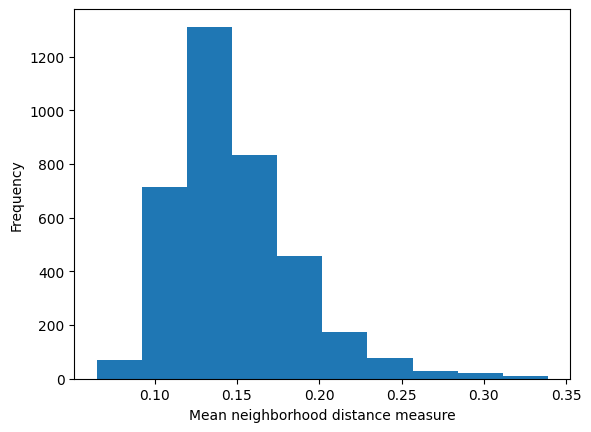

array([0.09385534, 0.17224505, 0.13133601, ..., 0.2579769 , 0.14114313,
       0.14486895])

In [137]:
neighborhood_smoothness(umap_velocity,p_t0)

In [145]:
node_velocity = t_1 - p_t0

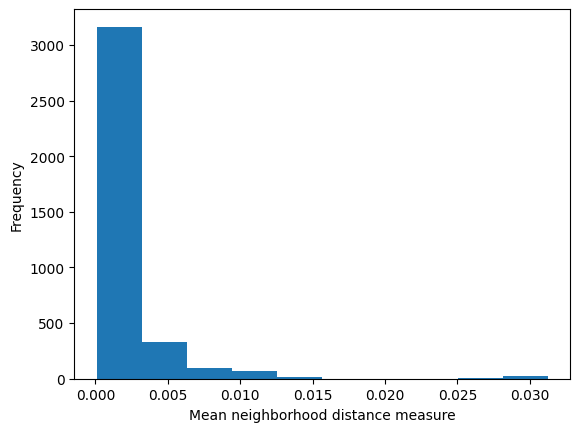

array([0.00377847, 0.0004497 , 0.00057449, ..., 0.00041509, 0.00643805,
       0.00178477])

In [146]:
neighborhood_smoothness(node_velocity,p_t0)